In [75]:
import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [77]:
def app (indices):
    omega = torch.tensor(2 * torch.pi * 0.5)  # f = 0.5
    if flag == True:
        h_accumulator = torch.zeros_like(torch.tensor([0.]), dtype=torch.float64)  # Initialize an empty tensor for h
        omega = omega * time_train[0]
        h = h_t_[0] * torch.sin(omega)
        h_accumulator = h
        return h_accumulator.unsqueeze(0)
    h_accumulator = torch.zeros_like(indices, dtype=torch.float64)  # Initialize an empty tensor for h
    
    for i in range(len(indices)):
        omega = omega * time_train[indices[i]]  # Assuming t is defined elsewhere
        h = h_t_[indices[i]] * torch.sin(omega)  # Assuming h_t is defined elsewhere
        h_accumulator[i] = h  # Store the calculated h in the accumulator tensor
    
    return h_accumulator.unsqueeze(0)  # Return the accumulator tensor
        

In [78]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    indices = torch.tensor(indices)
    return batch_y0,batch_t,batch_y,indices

In [79]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 60,y0 = [0.0,0.0])

[100.]
[60.]


In [80]:
h_t_ = torch.div(torch.tensor(h_t, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [81]:
data.shape

torch.Size([2, 600])

In [82]:
train = data[:,:].transpose(0,1).to(device)

In [83]:
train.shape

torch.Size([600, 2])

In [84]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(4, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,1024)
        self.lin5 = nn.Linear(1024,3)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        

    def forward(self,t,x):
        h = app(indices).view(-1,1).to(device)
        x_aug = torch.cat([x, h], 1)
        x = self.lrelu(self.lin(x_aug))
        x = self.lrelu(self.lin2(x))
        x = self.lrelu(self.lin3(x))
        x = self.tanh(self.lin4(x))
        x = self.lin5(x)
        return x
     

In [85]:
model = DWODE().double().to(device)

In [86]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [87]:
from torchdiffeq import odeint_adjoint as adjoint

In [88]:
time_train = torch.tensor(t).to(device)

In [89]:
flag = False

In [90]:
losses = []
whole_losses = []
best_loss = 100.0
for i in range(1000):
   
    optimizer.zero_grad()
    
    init,batch_t,truth,indices = get_batch(train,time_train,16)
    zeros = torch.zeros((len(init),1)).to(device)
    z0 = torch.cat((init, zeros), dim=1)
    #print(init,batch_t,truth)
    pred_y = adjoint(model,z0,batch_t,method='dopri5')
    loss = F.huber_loss(pred_y[:,:,:2], truth)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/forward_field_onlylrelu_3.pth')
    if i % 100 == 0:
        
        with torch.no_grad():
            flag = True
            zeros = torch.zeros((len(train[0].view(1,-1)),1)).to(device)
            z0 = torch.cat((train[0].view(1,-1), zeros), dim=1)
            pred_y = adjoint(model, z0.view(1,-1), time_train,method='dopri5')
            pred_y = pred_y.squeeze(1)
          
            loss = F.huber_loss(pred_y[:,:2], train)
            whole_losses.append(loss.item())
            flag = False
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            

            fig, ax = plt.subplots(2, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('Y_0')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y_1')
            ax[1].set_title('Projection')
            ax[1].legend()


            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
print(best_loss)

1.4595353567024528e-07


In [ ]:
test_model = DWODE().double().to(device)

In [ ]:
test_model.load_state_dict(torch.load('saved_models/forward_field_onlylrelu_3.pth'))

<All keys matched successfully>

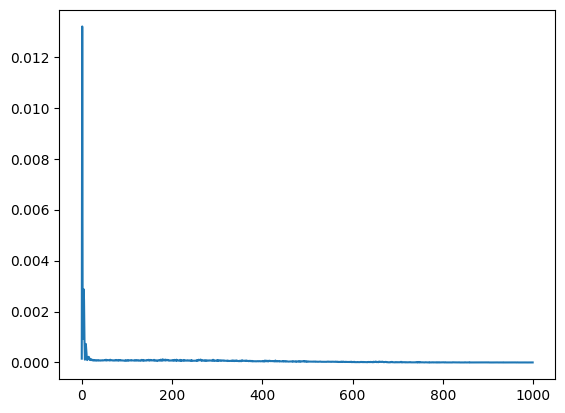

In [ ]:
plt.plot(losses)
plt.show()

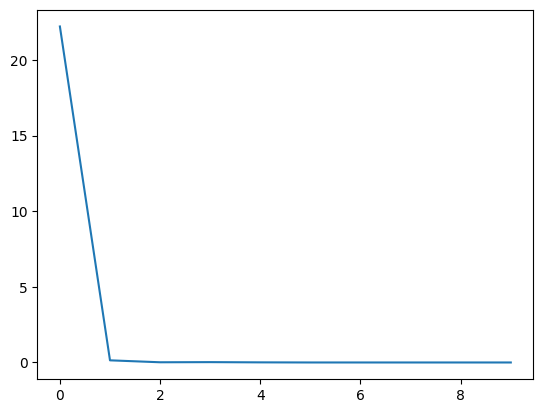

In [ ]:
plt.plot(whole_losses)

plt.show()

In [ ]:
with torch.no_grad():
    flag = True
    zeros = torch.zeros((len(train[0].view(1,-1)),1)).to(device)
    z0 = torch.cat((train[0].view(1,-1), zeros), dim=1)
    pred = adjoint(test_model, z0.view(1,-1), time_train,method='dopri5')
    flag = False

In [ ]:
pred = pred.cpu().detach().numpy()

In [ ]:
pred = pred.squeeze(1)

In [ ]:
pred.shape,train.shape

((600, 3), torch.Size([600, 2]))

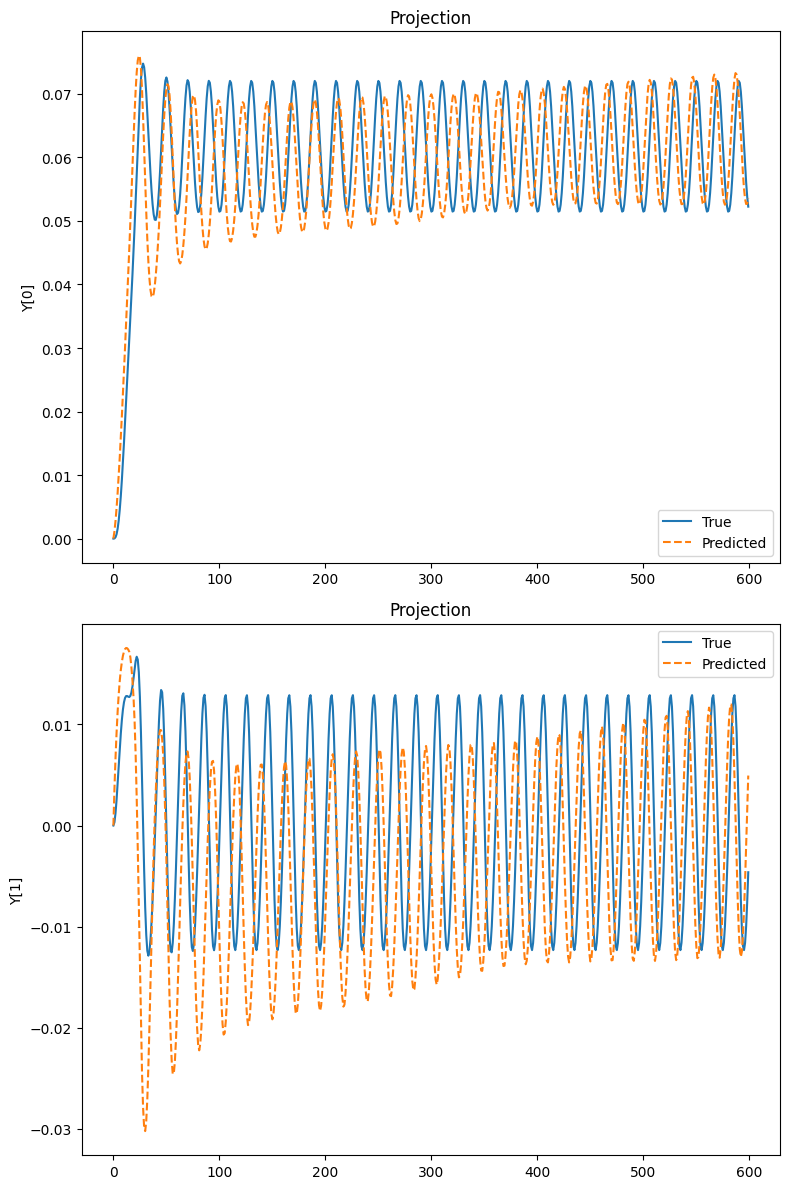

In [ ]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_AUG.png')
plt.tight_layout()
plt.show()

In [ ]:
t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 100,y0 = [60.0,0.0])

[100.]
[100.]


In [ ]:
h_t_ = torch.div(torch.tensor(ht, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [ ]:
test_train = torch.tensor(t_).to(device)

In [ ]:
test = data_[:,:].transpose(0,1).to(device)

In [ ]:
test_model = DWODE().double().to(device)

In [ ]:
test_model.load_state_dict(torch.load('saved_models/forward_field_onlylrelu_3.pth'))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    flag = True
    zeros = torch.zeros((len(test[0].view(1,-1)),1)).to(device)
    z0 = torch.cat((test[0].view(1,-1), zeros), dim=1)
    pred = adjoint(test_model, z0.view(1,-1), test_train,method='dopri5')
    flag = False

In [ ]:
pred = pred.cpu().detach().numpy()

In [ ]:
pred = pred.squeeze(1)

In [ ]:
pred.shape,test.shape

((1000, 3), torch.Size([1000, 2]))

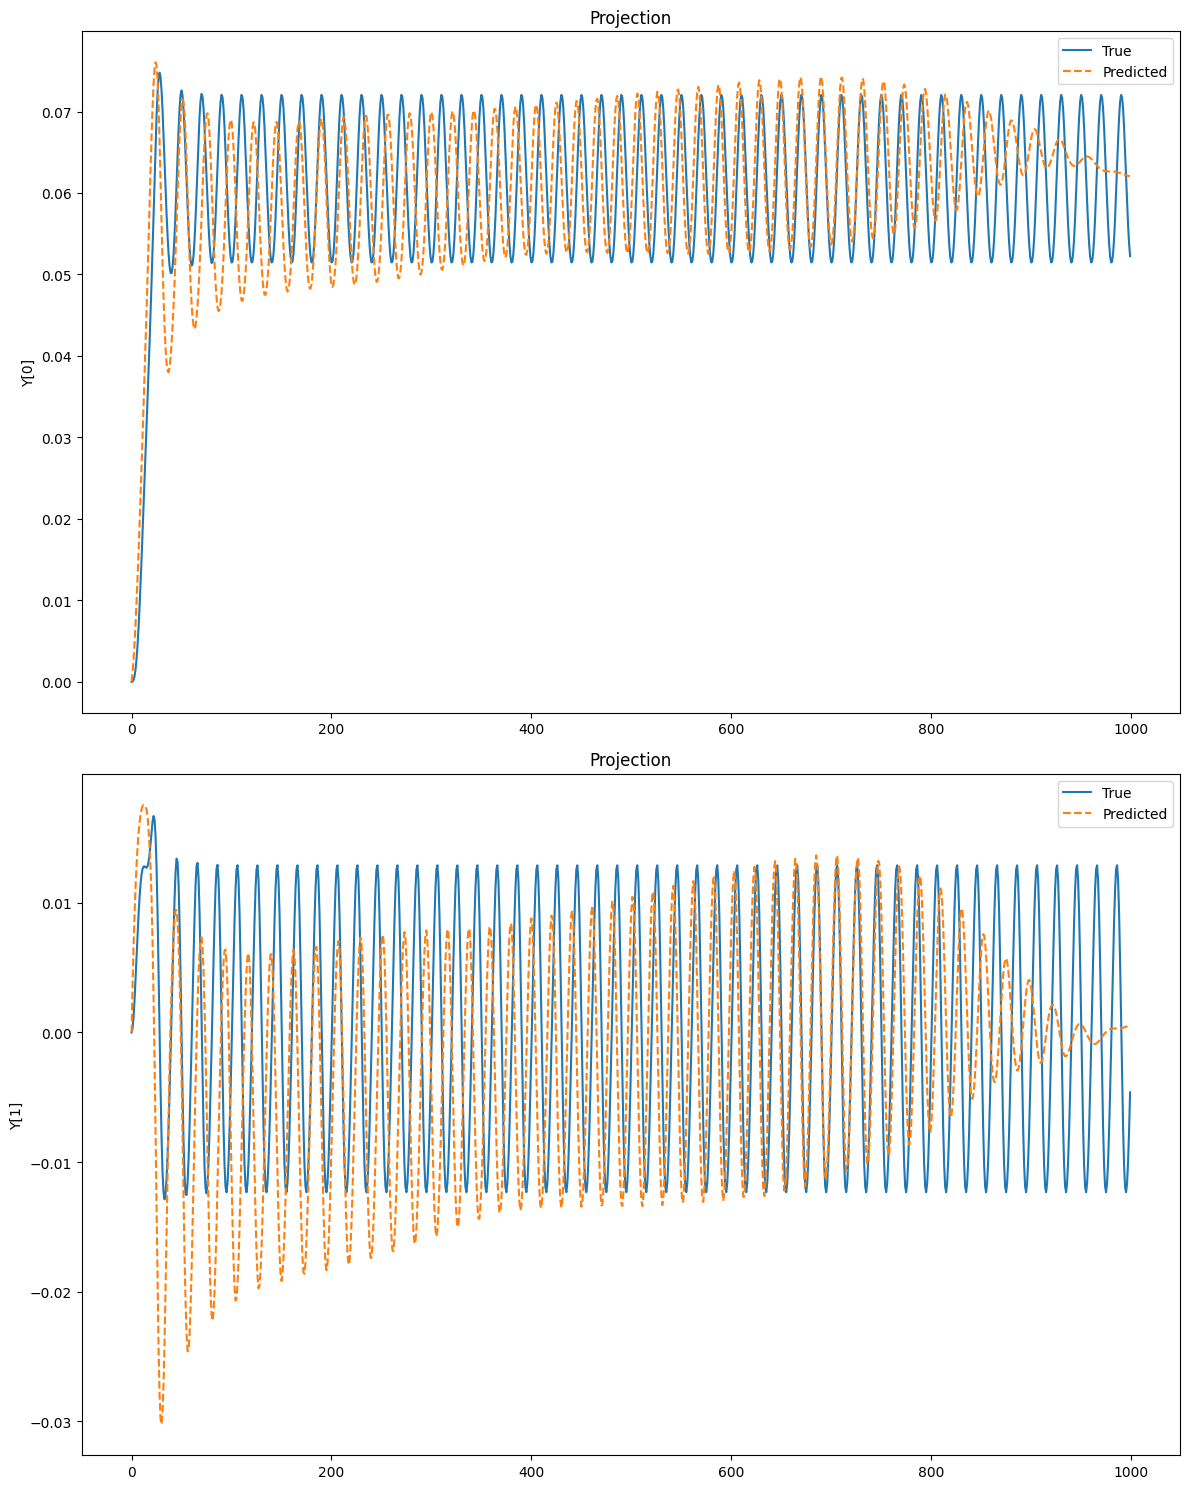

In [ ]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test[:,0].cpu()
y_train = test[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(12, 15))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('Y[0]')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[1]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('forward_field_onlylrelu_00pos_aug.png')
plt.tight_layout()
plt.show()